In [8]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [9]:
df = pd.read_csv('full_dataset.csv')
df

,date,year,month,TREFMXAV_U,FLNS,FSNS,PRECT,PRSN,QBOT,TREFHT,UBOT,VBOT,lat,lon,model
0,2006-01-01,2006,1,9.625855,41.925180,25.926952,4.663135e-09,4.781004e-17,0.004769,279.14288,3.878579,1.394184,53.246075,357.500000,3
1,2006-01-02,2006,1,11.321136,8.905806,10.946910,8.046593e-08,1.295726e-16,0.006271,281.14865,1.788157,3.821703,53.246075,357.500000,3
2,2006-01-03,2006,1,11.137970,16.511415,6.405902,2.910936e-09,4.094447e-16,0.005782,281.22380,0.804845,-2.299140,53.246075,357.500000,3
3,2006-01-04,2006,1,8.971100,29.948362,9.315041,7.432505e-11,0.000000e+00,0.004277,278.39767,-1.100267,-1.258029,53.246075,357.500000,3
4,2006-01-05,2006,1,7.740906,19.064156,7.941241,6.894238e-12,0.000000e+00,0.003990,278.06378,-0.706321,-0.938421,53.246075,357.500000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165138,2080-07-15,2080,7,22.155365,NaN,215.390100,4.232548e-13,NaN,NaN,NaN,NaN,NaN,53.248180,-2.502111,85
165139,2080-08-15,2080,8,24.427490,NaN,197.854190,1.110259e-13,NaN,NaN,NaN,NaN,NaN,53.248180,-2.502111,85
165140,2080-09-15,2080,9,22.779205,NaN,147.282270,7.228998e-14,NaN,NaN,NaN,NaN,NaN,53.248180,-2.502111,85
165141,2080-10-15,2080,10,19.056060,NaN,74.600730,2.394742e-13,NaN,NaN,NaN,NaN,NaN,53.248180,-2.502111,85


## Separate Application of LSTM to the 6 MME Datasets

training: 2006-1-1 to 2040-12-31, 35 years; validation: 2041-1-1 to 2049-12-31, 9 years; testing: 2050-1-1 to 2080-12-30

input sequence length： 7days

In [10]:
# Ensure the date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Parameter configuration
target_variable = 'TREFMXAV_U'
feature_variables = ['FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT', 'VBOT']
sequence_length = 7
rmse_results = {}

# Create output directories
prediction_dir = 'RF_MME_prediction'
os.makedirs(prediction_dir, exist_ok=True)

# Sequence generator
def create_sequences(data, feature_cols, target_col, seq_len):
    X, y, index = [], [], []
    f_data = data[feature_cols].values
    t_data = data[target_col].values
    time_index = data.index
    for i in range(len(data) - seq_len):
        X.append(f_data[i:i+seq_len].flatten())
        y.append(t_data[i+seq_len])
        index.append(time_index[i+seq_len])
    return np.array(X), np.array(y), index

# Loop through models 3–8
for model_id in range(3, 9):
    print(f"\nProcessing Random Forest for model {model_id}...")

    df_model = df[df['model'] == model_id].copy()
    df_model = df_model[['date'] + feature_variables + [target_variable]].dropna()
    df_model = df_model.sort_values('date').set_index('date')

    # Feature scaling
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    df_features_scaled = pd.DataFrame(feature_scaler.fit_transform(df_model[feature_variables]),
                                      columns=feature_variables, index=df_model.index)
    df_target_scaled = pd.DataFrame(target_scaler.fit_transform(df_model[[target_variable]]),
                                    columns=[target_variable], index=df_model.index)
    df_scaled = pd.concat([df_features_scaled, df_target_scaled], axis=1)

    # Time-based splits
    train_df = df_scaled.loc['2006-01-01':'2040-12-31']
    val_df = df_scaled.loc['2041-01-01':'2049-12-31']
    test_df = df_scaled.loc['2050-01-01':'2080-12-31']

    # Generate sequences
    X_train, y_train, idx_train = create_sequences(train_df, feature_variables, target_variable, sequence_length)
    X_val, y_val, _ = create_sequences(val_df, feature_variables, target_variable, sequence_length)
    X_test, y_test, idx_test = create_sequences(test_df, feature_variables, target_variable, sequence_length)

    # Build and train Random Forest model
    model = RandomForestRegressor(n_estimators=30, max_depth=20, random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred_rescaled = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    rmse_results[f'Model_{model_id}'] = rmse
    print(f"Model {model_id} - Test RMSE: {rmse:.3f}")

    # Save prediction results
    def save_predictions(X, y, idx, label):
        y_pred = model.predict(X)
        y_pred_rescaled = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
        y_true_rescaled = target_scaler.inverse_transform(y.reshape(-1, 1))
        df_out = pd.DataFrame({
            'date': idx,
            'Actual': y_true_rescaled.flatten(),
            'Predicted': y_pred_rescaled.flatten()
        })
        output_path = os.path.join(prediction_dir, f'model_{model_id}_{label}_predictions.csv')
        df_out.to_csv(output_path, index=False)

    save_predictions(X_train, y_train, idx_train, 'train')
    save_predictions(X_test, y_test, idx_test, 'test')



Processing Random Forest for model 3...
Model 3 - Test RMSE: 2.031

Processing Random Forest for model 4...
Model 4 - Test RMSE: 1.979

Processing Random Forest for model 5...
Model 5 - Test RMSE: 1.965

Processing Random Forest for model 6...
Model 6 - Test RMSE: 2.018

Processing Random Forest for model 7...
Model 7 - Test RMSE: 2.039

Processing Random Forest for model 8...
Model 8 - Test RMSE: 2.060


Plotting test prediction for model 3...


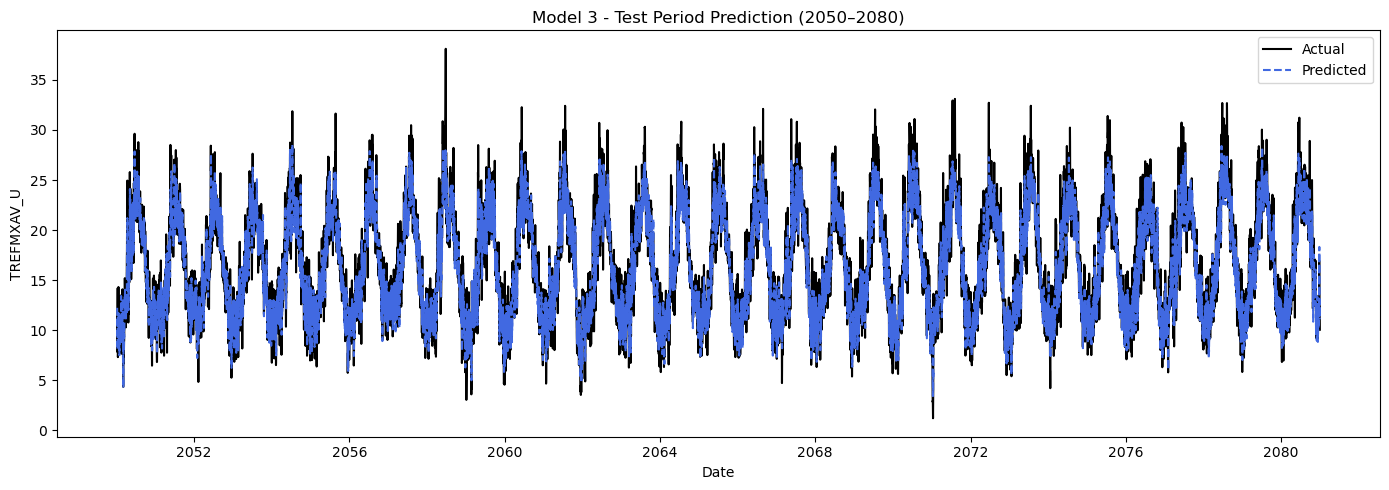

Plotting test prediction for model 4...


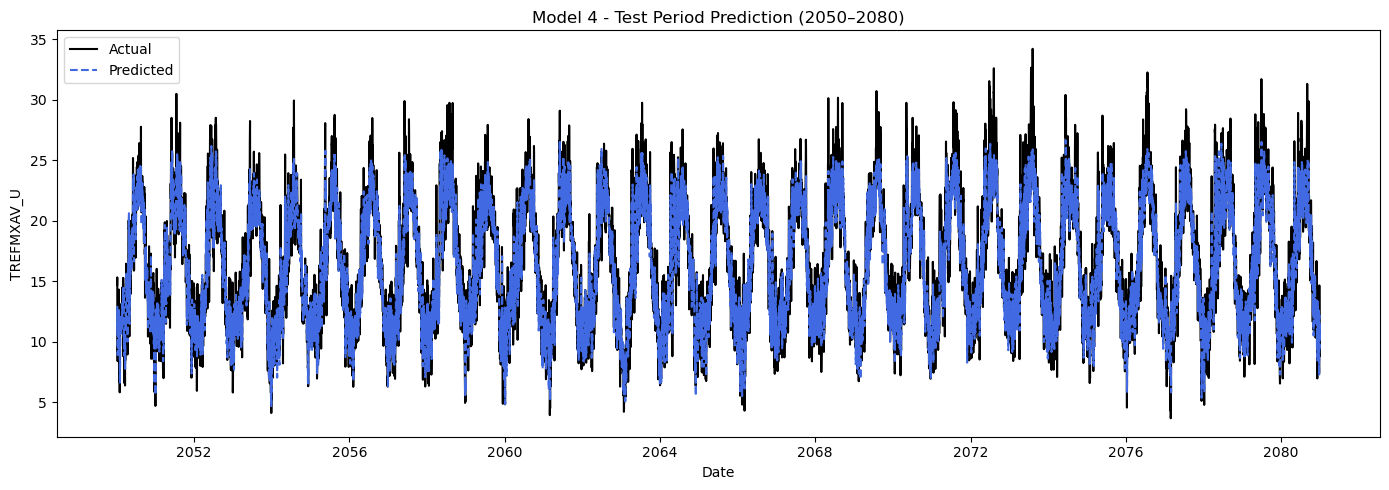

Plotting test prediction for model 5...


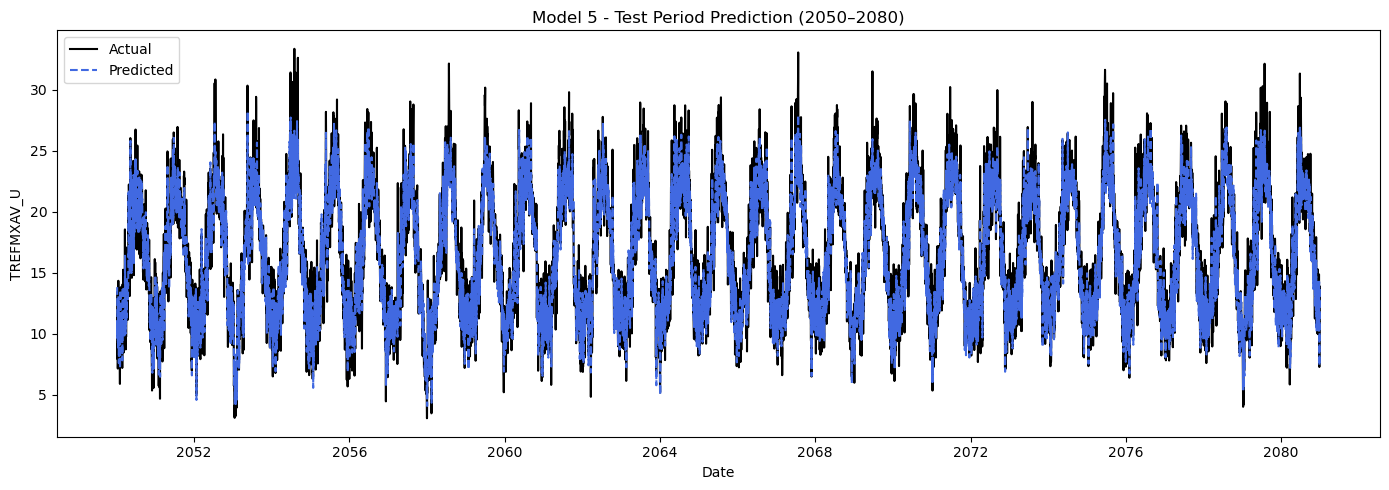

Plotting test prediction for model 6...


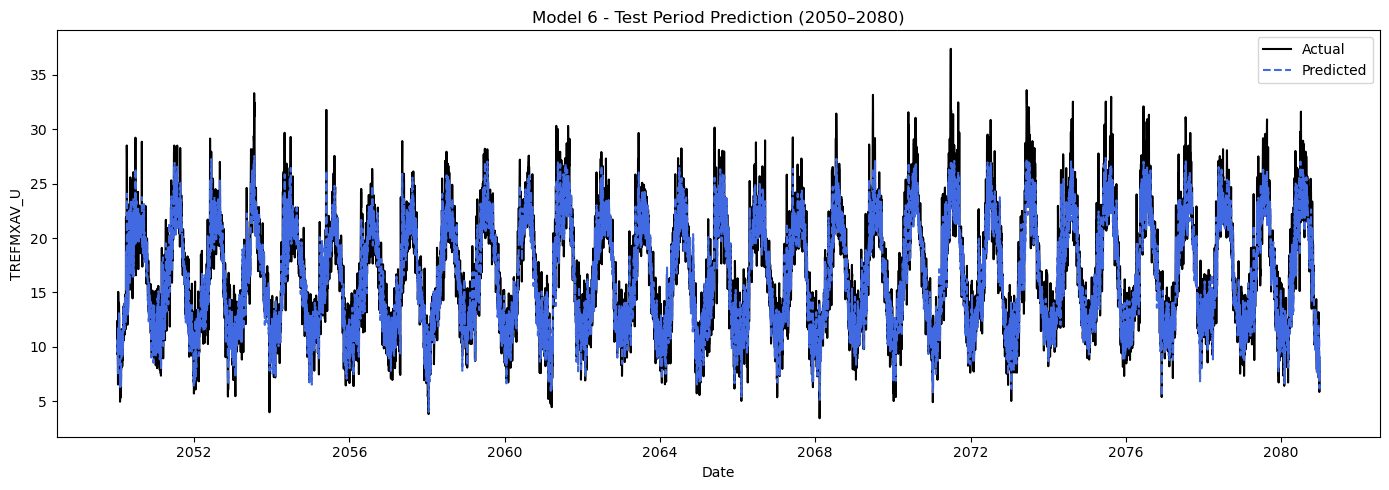

Plotting test prediction for model 7...


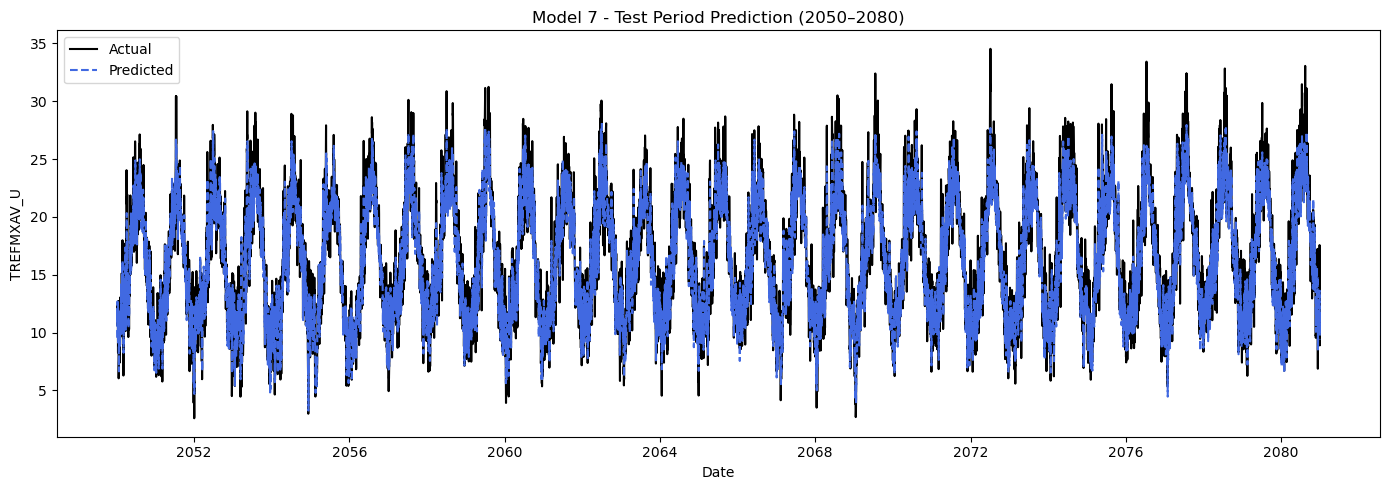

Plotting test prediction for model 8...


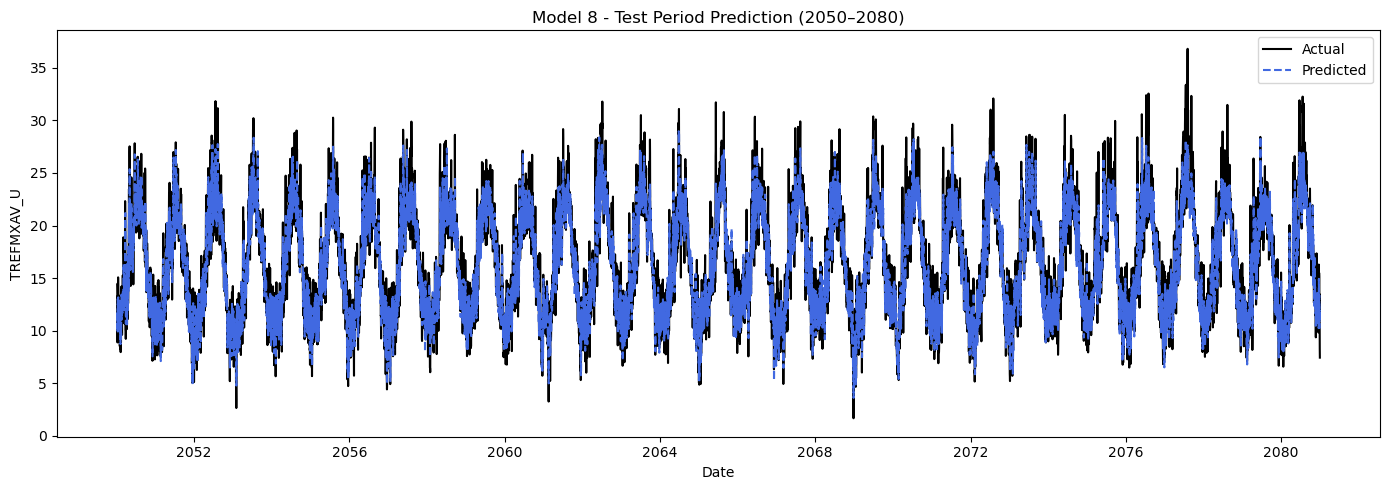

In [11]:
# Create a directory to save the plots
plot_dir = 'RF_MME_Test_plot'
os.makedirs(plot_dir, exist_ok=True)

# Loop through models 3–8, read predictions and plot
for model_id in range(3, 9):
    print(f"Plotting test prediction for model {model_id}...")

    # Read test prediction data from the LSTM_MME_prediction folder
    file_path = f'RF_MME_prediction/model_{model_id}_test_predictions.csv'
    test_df = pd.read_csv(file_path, parse_dates=['date'])

    # Plot actual vs predicted
    plt.figure(figsize=(14, 5))
    plt.plot(test_df['date'], test_df['Actual'], label='Actual', color='black')
    plt.plot(test_df['date'], test_df['Predicted'], label='Predicted', linestyle='--', color='royalblue')
    plt.title(f'Model {model_id} - Test Period Prediction (2050–2080)')
    plt.xlabel('Date')
    plt.ylabel('TREFMXAV_U')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()

    # Save the plot to the LSTM_MME_Test_plot folder
    plt.savefig(f'{plot_dir}/model_{model_id}_test_plot.png')
    plt.show()

## Application of Ramdom forest to the CHESS Dataset

training: 2006-1 to 2040-12; validation: 2041-1 to 2049-12; testing: 2050-1 to 2080-11

input sequence length: 3 months

In [12]:
# Ensure the date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Parameter configuration (for model 85)
model_id = 85
target_variable = 'TREFMXAV_U'
feature_variables = ['PRECT', 'FSNS']
sequence_length = 3

# Create directories for saving predictions
prediction_dir = 'RF_CHESS_prediction'
os.makedirs(prediction_dir, exist_ok=True)

print(f"\nProcessing Random Forest for model {model_id}...")

# Filter model 85 data (without modifying the original df)
df_model = df[df['model'] == model_id].copy()
df_model = df_model[['date'] + feature_variables + [target_variable]].dropna()
df_model = df_model.sort_values('date').set_index('date')

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
features_scaled = pd.DataFrame(
    feature_scaler.fit_transform(df_model[feature_variables]),
    columns=feature_variables,
    index=df_model.index
)
target_scaled = pd.DataFrame(
    target_scaler.fit_transform(df_model[[target_variable]]),
    columns=[target_variable],
    index=df_model.index
)
df_scaled = pd.concat([features_scaled, target_scaled], axis=1)

# Split into training, validation, and test sets (by month)
train_df = df_scaled.loc['2006-01':'2040-12']
val_df = df_scaled.loc['2041-01':'2049-12']
test_df = df_scaled.loc['2050-01':'2080-11']

# Create sequences
X_train, y_train, idx_train = create_sequences(train_df, feature_variables, target_variable, sequence_length)
X_val, y_val, _ = create_sequences(val_df, feature_variables, target_variable, sequence_length)
X_test, y_test, idx_test = create_sequences(test_df, feature_variables, target_variable, sequence_length)

# Build and train Random Forest model
model = RandomForestRegressor(n_estimators=30, max_depth=20, random_state=42)
model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = model.predict(X_test)
y_pred_rescaled = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Model {model_id} - Test RMSE: {rmse:.3f}")

# Save prediction results (training + test)
def save_predictions(X, y, idx, label):
    y_pred = model.predict(X)
    y_pred_rescaled = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_true_rescaled = target_scaler.inverse_transform(y.reshape(-1, 1))
    df_out = pd.DataFrame({
        'date': idx,
        'Actual': y_true_rescaled.flatten(),
        'Predicted': y_pred_rescaled.flatten()
    })
    output_path = os.path.join(prediction_dir, f'model_{model_id}_{label}_predictions.csv')
    df_out.to_csv(output_path, index=False)

save_predictions(X_train, y_train, idx_train, 'train')
save_predictions(X_test, y_test, idx_test, 'test')


Processing Random Forest for model 85...
Model 85 - Test RMSE: 2.584


Plotting test prediction for model 85


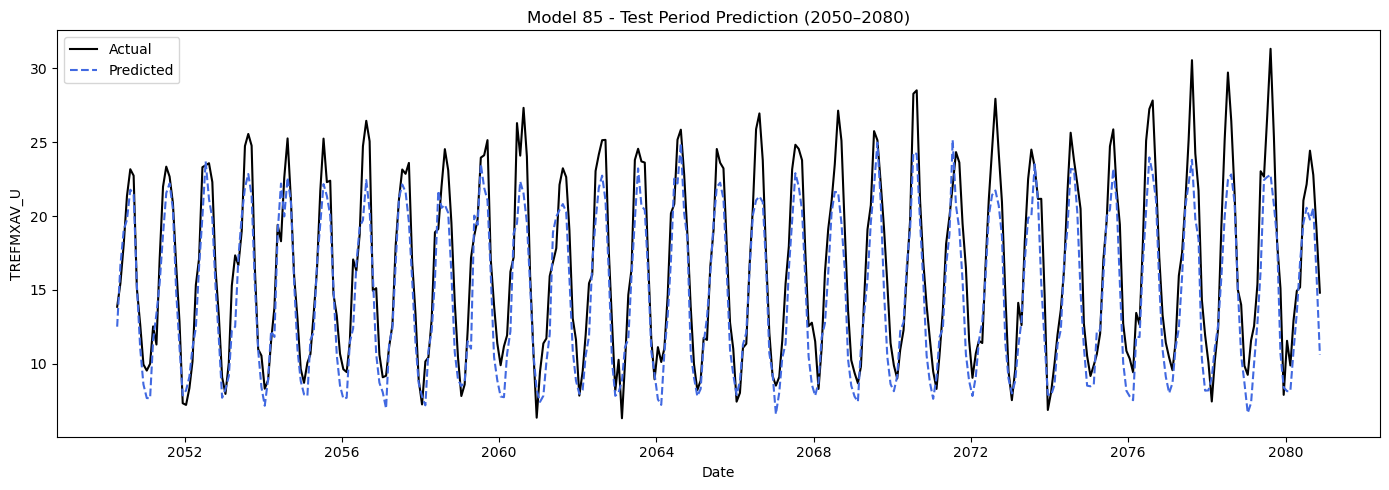

In [13]:
# Create directory to save the plot
plot_dir = 'RF_CHESS_Test_plot'
os.makedirs(plot_dir, exist_ok=True)

# Read predictions and plot
print(f"Plotting test prediction for model 85")

# Read test prediction data from the LSTM_CHESS_prediction folder
file_path = f'RF_CHESS_prediction/model_{model_id}_test_predictions.csv'
test_df = pd.read_csv(file_path, parse_dates=['date'])

# Plot actual vs predicted
plt.figure(figsize=(14, 5))
plt.plot(test_df['date'], test_df['Actual'], label='Actual', color='black')
plt.plot(test_df['date'], test_df['Predicted'], label='Predicted', linestyle='--', color='royalblue')
plt.title(f'Model {model_id} - Test Period Prediction (2050–2080)')
plt.xlabel('Date')
plt.ylabel('TREFMXAV_U')
plt.legend()
plt.grid(False)
plt.tight_layout()

# Save the plot to the test_plot folder
plt.savefig(f'{plot_dir}/model_{model_id}_test_plot.png')
plt.show()